In [1]:
!wget https://raw.githubusercontent.com/EdwardRaff/Inside-Deep-Learning/main/idlmam.py

--2023-05-10 17:57:46--  https://raw.githubusercontent.com/EdwardRaff/Inside-Deep-Learning/main/idlmam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22064 (22K) [text/plain]
Saving to: ‘idlmam.py’

idlmam.py           100%[===================>]  21.55K  --.-KB/s    in 0s      

2023-05-10 17:57:46 (89.2 MB/s) - ‘idlmam.py’ saved [22064/22064]



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, View, weight_reset,  set_seed

<ipython-input-2-816656b77a98>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

<ipython-input-3-024163930d81>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#Hidden layer size
n = 2 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

In [46]:
class TransposeLinear(nn.Module):
  def __init__(self, linear_layer: nn.Linear, bias=True):
    super().__init__()

    self.weight = linear_layer.weight
    if bias:
      self.bias = nn.Parameter(torch.Tensor(linear_layer.weight.shape[1]))
    else:
      self.register_parameter('bias', None)

  def forward(self, x):
    return F.linear(x, self.weight.t(), self.bias)

In [47]:
linear_layer = nn.Linear(D, n, bias=False)

pca_encoder = nn.Sequential(
    nn.Flatten(),
    linear_layer
)

pca_decoder = nn.Sequential(
    TransposeLinear(linear_layer, bias=False),
    View(-1, 1, 28, 28)
)

pca_model = nn.Sequential(
    pca_encoder,
    pca_decoder
)

In [48]:
nn.init.orthogonal_(linear_layer.weight)

Parameter containing:
tensor([[-0.0063, -0.0112, -0.0474,  ...,  0.0428,  0.0234, -0.0159],
        [-0.0503,  0.0659, -0.0364,  ...,  0.0330,  0.0096,  0.0341]],
       requires_grad=True)

In [7]:
mse_loss = nn.MSELoss()

def mse_with_orthoLoss(x, y):#our PCA loss function
  W = linear_layer.weight
  I = torch.eye(W.shape[0]).to(device)
  normal_loss =  mse_loss(x, y) 
  regularization_loss = 0.1*mse_loss(torch.mm(W, W.t()), I)
  return normal_loss + regularization_loss

In [8]:
class AutoEncodeDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    x, y = self.dataset.__getitem__(idx)
    return x, x

In [16]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [74]:
train_network(pca_model, mse_with_orthoLoss, train_loader, test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,val loss
0,0,9.758187,0.058384,0.057895
1,1,19.528354,0.057932,0.057803
2,2,29.238222,0.057889,0.057796
3,3,38.430585,0.057885,0.057832
4,4,47.531132,0.057890,0.057833
5,5,56.753018,0.057888,0.057783
6,6,66.437602,0.057893,0.057827
7,7,76.269245,0.057889,0.057884
8,8,85.948897,0.057890,0.057815
9,9,95.988669,0.057890,0.057803


In [10]:
def showEncodeDecode(encode_decode, x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    """
    #Switch to eval mode
    encode_decode = encode_decode.eval()
    #We will move things to the CPU so that we don't have to think about what device anything was on
    #and because this functino is not performance sensative
    encode_decode = encode_decode.cpu()
    with torch.no_grad():#Always no_grad if you are not training
        x_recon = encode_decode(x.cpu())
    #Use matplotlib to create a size-by-side plot with the original on the left
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

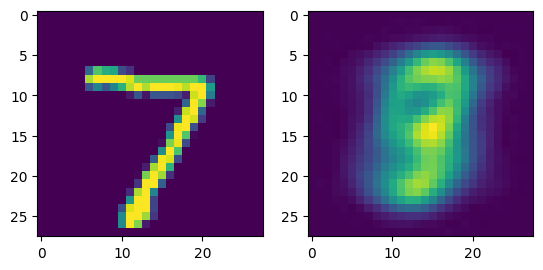

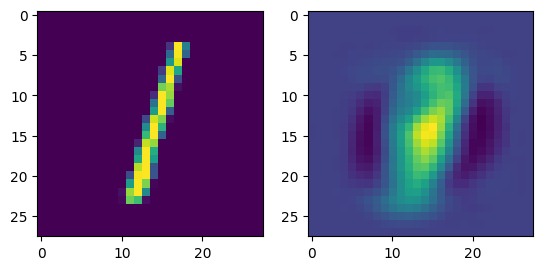

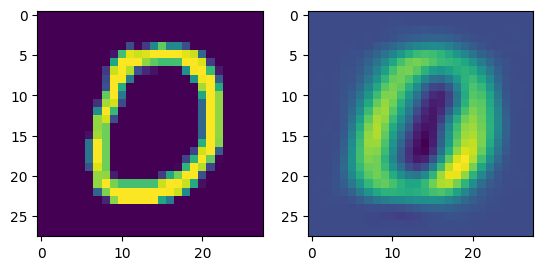

In [76]:
#Showing the input (left) and output (right) for three data points
showEncodeDecode(pca_model, test_data_xy[0][0])
showEncodeDecode(pca_model, test_data_xy[2][0])
showEncodeDecode(pca_model, test_data_xy[10][0])

In [11]:
pca_nonlinear_encode = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh()
)

pca_nonlinear_decode = nn.Sequential(
    nn.Linear(n, D),
    View(-1, 1, 28, 28)
)

pca_nonlinear = nn.Sequential(
    pca_nonlinear_encode,
    pca_nonlinear_decode
)

In [12]:
train_network(pca_nonlinear, mse_loss, train_loader, test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,val loss
0,0,12.960859,0.133443,0.069232
1,1,23.795255,0.066575,0.066115
2,2,33.990343,0.065637,0.065486
3,3,43.907980,0.064898,0.064571
4,4,53.684726,0.063828,0.063268
5,5,63.078864,0.062310,0.061494
6,6,72.263813,0.060461,0.059607
7,7,81.445605,0.058855,0.058278
8,8,90.745399,0.057840,0.057487
9,9,100.570038,0.057270,0.057058


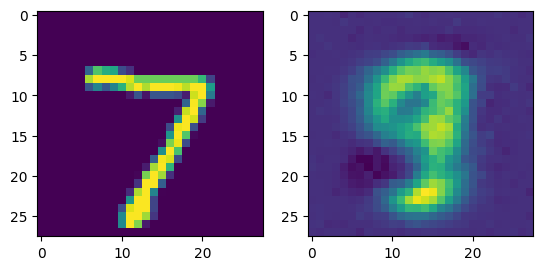

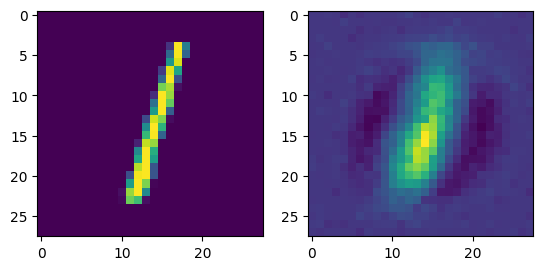

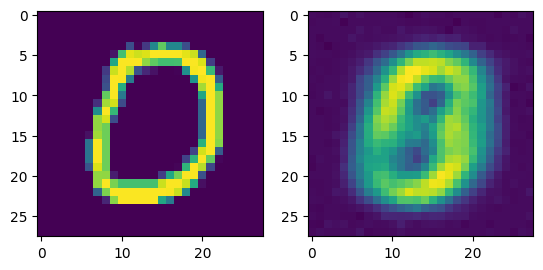

In [15]:
#Showing the input (left) and output (right) for three data points
showEncodeDecode(pca_nonlinear, test_data_xy[0][0])
showEncodeDecode(pca_nonlinear, test_data_xy[2][0])
showEncodeDecode(pca_nonlinear, test_data_xy[10][0])

In [11]:
def get_layer(in_size, out_size):
  h = nn.Sequential(
      nn.Linear(in_size, out_size),
      nn.BatchNorm1d(out_size),
      nn.ReLU()
  )
  return h

In [12]:
normal = torch.distributions.Normal(0, 0.5)
def add_noise(x, device='cpu'):
  return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

class AdditiveGaussNoise(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    if self.training:
      return add_noise(x, device=device)
    else:
      return x

In [18]:
auto_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.2),
    get_layer(D, D*2),
    nn.Dropout(),
    get_layer(D*2, D*2),
    nn.Dropout(),
    get_layer(D*2, D*2),
    nn.Dropout(),
    nn.Linear(D*2, D*2)
)

auto_decoder = nn.Sequential(
    get_layer(D*2, D*2),
    nn.Dropout(),
    get_layer(D*2, D*2),
    nn.Dropout(),
    get_layer(D*2, D*2),
    nn.Dropout(),
    nn.Linear(D*2, D),
    View(-1, 1, 28, 28)
)

auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

In [19]:
train_network(auto_encode_decode, mse_loss, train_loader, test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,val loss
0,0,16.653952,0.062949,0.034043
1,1,36.328971,0.037938,0.028340
2,2,53.569757,0.033698,0.025138
3,3,70.356471,0.031291,0.021953
4,4,87.531639,0.029815,0.021669
5,5,104.388256,0.028784,0.020378
6,6,121.657603,0.028056,0.019669
7,7,138.605620,0.027505,0.018857
8,8,155.804174,0.027151,0.018494
9,9,172.701337,0.026693,0.017650


In [ ]:
showEncodeDecode(auto_encode_decode, test_data_xy[2][0])
showEncodeDecode(auto_encode_decode, add_noise(test_data_xy[2][0]))

showEncodeDecode(auto_encode_decode, test_data_xy[6][0])
showEncodeDecode(auto_encode_decode, add_noise(test_data_xy[6][0]))

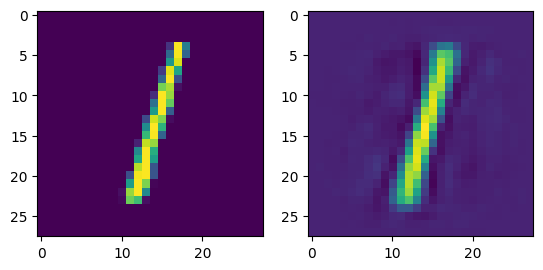

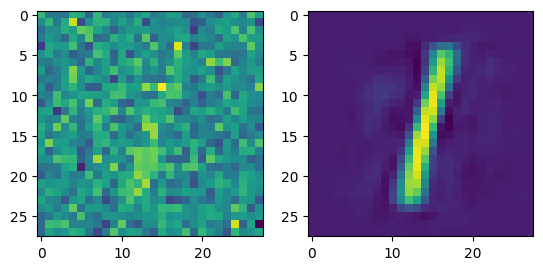

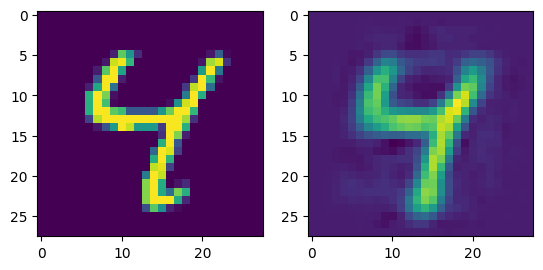

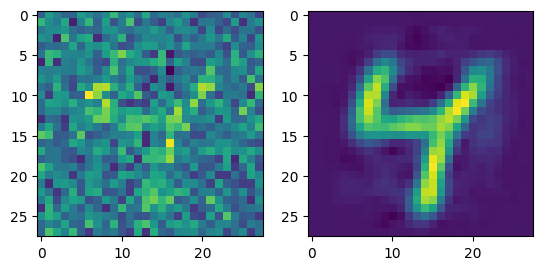

In [20]:
showEncodeDecode(auto_encode_decode, test_data_xy[2][0])
showEncodeDecode(auto_encode_decode, add_noise(test_data_xy[2][0]))

showEncodeDecode(auto_encode_decode, test_data_xy[6][0])
showEncodeDecode(auto_encode_decode, add_noise(test_data_xy[6][0]))

In [6]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

all_data = []
resp = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")
shakespear_100k = resp.read()
shakespear_100k = shakespear_100k.decode('utf-8').lower()

In [7]:
vocab2idx = {}
for char in shakespear_100k:
  if char not in vocab2idx:
    vocab2idx[char] = len(vocab2idx)

idx2vocab = {}
for k, v in vocab2idx.items():
  idx2vocab[v] = k

In [8]:
print("Vocab Size: ", len(vocab2idx))
print("Total Char: ", len(shakespear_100k))

Vocab Size:  36
Total Char:  99993


In [14]:
class AutoRegressiveDataset(Dataset):
  def __init__(self, string, max_chunk=500):
    self.doc = string
    self.max_chunk = max_chunk

  def __len__(self):
    return (len(self.doc) - 1) // self.max_chunk

  def __getitem__(self, idx):
    start = idx*self.max_chunk
    sub_string = self.doc[start:start+self.max_chunk]
    x = [vocab2idx[c] for c in sub_string]
    sub_string = self.doc[start+1:start+self.max_chunk+1]
    y = [vocab2idx[c] for c in sub_string]
    return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)

In [10]:
class AutoreRegressive(nn.Module):
  def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
    super().__init__()

    self.hidden_size = hidden_size
    self.embd = nn.Embedding(num_embeddings, embd_size)

    self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] + [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
    self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])

    self.pred_class = nn.Sequential(
        nn.Linear(hidden_size, hidden_size), 
        nn.LeakyReLU(),
        nn.LayerNorm(hidden_size),
        nn.Linear(hidden_size, num_embeddings)
    )

  def init_hidden_states(self, B):
    return [
        torch.zeros(B, self.hidden_size, device=device)
        for _ in range(len(self.layers))
    ]

  def step(self, x_in, h_prevs=None):
    if len(x_in.shape) == 1:
      x_in = self.embd(x_in)
    
    if h_prevs is None:
      h_prevs = self.init_hidden_states(x_in.shape[0])

    for l in range(len(self.layers)):
      h_prev = h_prevs[l]
      h = self.norms[l](self.layers[l](x_in, h_prev))
      
      h_prevs[l] = h
      x_in = h

    return self.pred_class(x_in)

  def forward(self, x):
    B = x.size(0)
    T = x.size(1)

    x = self.embd(x)
    h_prevs = self.init_hidden_states(B)

    last_activations = []
    for t in range(T):
      x_in = x[:, t, :]
      last_activations.append(self.step(x_in, h_prevs))

    last_activations = torch.stack(last_activations, dim=1)
    return last_activations


In [15]:
auto_reg_data = AutoRegressiveDataset(shakespear_100k, max_chunk=250)
auto_reg_loader = DataLoader(auto_reg_data, batch_size=128, shuffle=True)

model = AutoreRegressive(len(vocab2idx), 32, 128, 2)
model = model.to(device)

for p in model.parameters():
  p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [16]:
def cross_ent_loss_time(x, y):
  cel = nn.CrossEntropyLoss()
  T = x.size(1)
  loss = 0
  for t in range(T):
    loss += cel(x[:,t,:], y[:,t])
  return loss

In [17]:
train_network(model, cross_ent_loss_time, auto_reg_loader, epochs=100, device=device)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

,epoch,total time,train loss
0,0,4.749218,880.891342
1,1,6.698725,798.990753
2,2,8.228814,776.959915
3,3,9.747026,764.654343
4,4,11.260822,761.648010
...,...,...,...
95,95,160.412847,405.086861
96,96,161.937726,405.140083
97,97,163.458146,402.758118
98,98,165.348031,402.961685


In [41]:
model = model.eval()
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)


In [42]:
seed = "EMILIA:".lower()
cur_len = len(seed)
temperature = 0.75
sampling[0,:cur_len] = torch.tensor([vocab2idx[x] for x in seed])

In [46]:
with torch.no_grad():
  #initialize the hidden state to avoid redundant work
  h_prevs = model.init_hidden_states(1)
  #push the seed through
  for i in range(0, cur_len):
    h = model.step(sampling[:,i], h_prevs=h_prevs)

  #generate new text one character at a time
  for i in tqdm(range(cur_len, sampling.size(1))):
    h = F.softmax(h/temperature, dim=1) #make probabilities
    next_tokens = torch.multinomial(h, 1)
    sampling[:,i] = next_tokens
    cur_len += 1
    #now push only the new sample into the model
    h = model.step(sampling[:,i], h_prevs=h_prevs)

  0%|          | 0/493 [00:00<?, ?it/s]

In [47]:
s = [idx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print(''.join(s))

emilia:
i nimencaust, hone now every hath not fear,
the have me the to do trom somean!
and for your deed for the life,
what mard,
when disding estemply hands,
and peipores, and in the true,
that for the shall should sost!

titol:
weren great hands upon dearly strue.

bark:
hold king of your dead to trom all eniced or tomeen are
tatage?

erisal:
do comphily you greatraw ut,
bear for conlemptes and sufformance.
and life and rade
theness of drayors.

duke conus:
lork then but but a prach to to true
